In [ ]:
## TODO: Add Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import pandas as pd
from datetime import date

pd.get_option("display.max_rows",100)
'''/home/alonshp/.conda/envs/tf-env/bin/python'''

# sys.path.append(os.path.abspath('../'))
# print(sys.path)

'/home/alonshp/.conda/envs/tf-env/bin/python'

In [3]:
from percantage_replicates_utils import *
# from constants import *
from metrics import *

In [4]:
new_exp = True

if new_exp:
    today = date.today()
    date = today.strftime("%d_%m")
    date
else:
    date = '04_06'

# Load data

In [15]:
ds_info_dict={'CDRP':['CDRP-BBBC047-Bray',['Metadata_Sample_Dose','pert_sample_dose']],
              'CDRP-bio':['CDRPBIO-BBBC036-Bray',['Metadata_Sample_Dose','pert_sample_dose']],
              'TAORF':['TA-ORF-BBBC037-Rohban',['Metadata_broad_sample','pert_id',]],
              'LUAD':['LUAD-BBBC041-Caicedo',['x_mutation_status','allele']],
              'LINCS':['LINCS-Pilot1',['Metadata_pert_id_dose','pert_id_dose']]}

################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
# datasets=['LUAD','TAORF','LINCS','CDRP-bio'];
# datasets=['LINCS', 'CDRP-bio','CDRP'];
# datasets=['TAORF','LUAD','LINCS', 'CDRP-bio']
datasets=['CDRP-bio']
# DT_kfold={'LUAD':10, 'TAORF':5, 'LINCS':25, 'CDRP-bio':6,'CDRP':40}



# from IPython.display import clear_output
################################################
# CP Profile Type options: 'augmented', 'augmented_after_fs' , 'normalized', 'normalized_variable_selected'
profileType='augmented'
profileType ='normalized_variable_selected'
# profileType='augmented_after_fs'

base_dir= '/sise/assafzar-group/assafzar/genesAndMorph'
data_dir=base_dir+'/preprocessed_data/'+ds_info_dict[datasets[0]][0]+'/'
output_dir = f'{base_dir}/anomaly_output/{datasets[0]}/{profileType}'  
save_base_dir = f'{base_dir}/results/{datasets[0]}/{profileType}/'
exp_save_dir = f'{save_base_dir}/{date}'
exp_name= 'autoencoder'

os.makedirs(save_base_dir,exist_ok=True)
os.makedirs(exp_save_dir,exist_ok=True)


methods_info_dicts = {
    # '4to1':{'path':f'/storage/users/g-and-n/tabular_models_results/41/ALL/zscores'},
    # '2to1':{'path':f'/storage/users/g-and-n/tabular_models_results/21/ALL/zscores'},
    'anomaly':{'name':'anomaly','path':os.path.join(output_dir,'out_ad_treated_zscores.csv')},
    'raw':{'name':'raw','path': os.path.join(output_dir,'input_data_test_treated_zscores_by_test.csv')},
    # '5to5':{'path':f'/storage/users/g-and-n/tabular_models_results/55/ALL/zscores'},
}


In [16]:
methods_for_testing = ['anomaly','raw']

methods = {}
for m in methods_for_testing:
    methods[m] = methods_info_dicts[m]

In [17]:
def set_index_fields(df, index_fields=None):

    if index_fields is None:
        index_fields = ['Metadata_Plate', 'Metadata_ASSAY_WELL_ROLE', 'Metadata_broad_sample', 'Metadata_Well',
                        'Metadata_mmoles_per_liter']
    df = df.set_index(
        index_fields)
    return df


In [18]:
for m in methods.keys():
    
    zscores = pd.read_csv(methods[m]['path'], compression = 'gzip')
    
    methods[m]['features'] = zscores.columns[zscores.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
    zscores = set_index_fields(zscores)
    methods[m]['zscores'] = zscores.loc[:,methods[m]['features']]

In [19]:
print(methods['raw']['zscores'].shape,methods['anomaly']['zscores'].shape)

(17594, 602) (17594, 574)


In [ ]:
methods['raw']['zscores'].head()

In [ ]:
methods['anomaly']['zscores'].head()

## Investigate Plate Effects

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
import umap


pcas={}
tsnes={}
umaps={}

for m in methods.keys():
    # if model!='pure':
    x = methods[m]['zscores'][methods[m]['features']]
    x= x.fillna(0)

    sc = StandardScaler()
    X_scaled = sc.fit_transform(x.values)

    print('Running PCA...')

    pca = PCA(n_components=2)
    # x_pca = pca.fit_transform(X_scaled, allow_nan=True)
    pcas[m] = pca.fit_transform(X_scaled)

    print('Running TSNE...')

    t_sne = manifold.TSNE(
        n_components=2,
        perplexity=25,
        init="random",
        n_iter=250,
        random_state=0,
    )
    tsnes[m] = t_sne.fit_transform(X_scaled)

    print('Running UMAP...')

    reducer = umap.UMAP()
    umaps[m] = reducer.fit_transform(X_scaled)


Running PCA...
Running TSNE...


/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Running UMAP...
Running PCA...
Running TSNE...


/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Running UMAP...


In [21]:
for m in pcas.keys():
    # if model!='pure':
        a = methods[m]['zscores'][methods[m]['features']].copy().reset_index()
        print(a['Metadata_Plate'].value_counts())

25966    321
25992    321
25991    321
25990    321
25989    321
25955    321
24321    321
25965    321
24306    321
24277    320
24278    320
25944    320
25945    320
25949    320
25983    320
25967    320
25968    320
25984    320
25985    320
25988    320
26224    320
26232    320
24352    320
26247    320
24304    320
24310    320
24301    320
24302    320
24303    320
24319    320
24305    320
24307    320
24308    320
24309    320
24311    320
24293    320
24279    320
24312    320
24313    320
24296    320
24297    319
24294    319
24280    319
26239    319
24295    319
24320    319
25987    319
25986    319
24300    319
25962    319
25943    319
25939    319
25938    319
25937    319
24357    319
Name: Metadata_Plate, dtype: int64
25966    321
25992    321
25991    321
25990    321
25989    321
25955    321
24321    321
25965    321
24306    321
24277    320
24278    320
25944    320
25945    320
25949    320
25983    320
25967    320
25968    320
25984    320
25985    320
259

DNN with (17594, 581)


/tmp/ipykernel_46427/3049357987.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


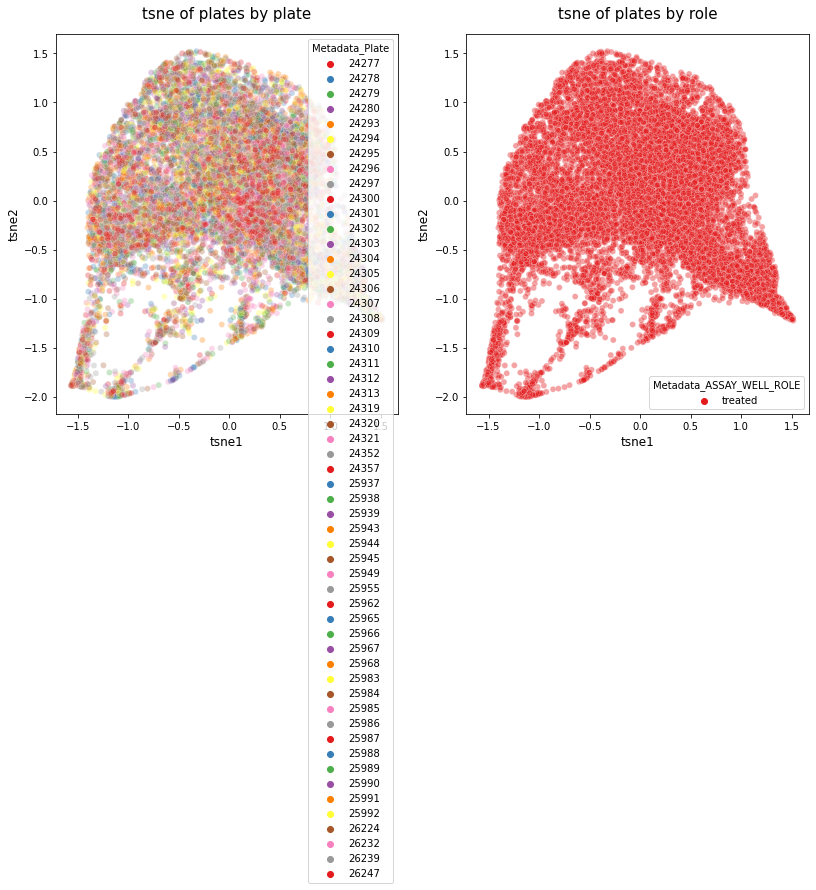

DNN with (17594, 609)


/tmp/ipykernel_46427/3049357987.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


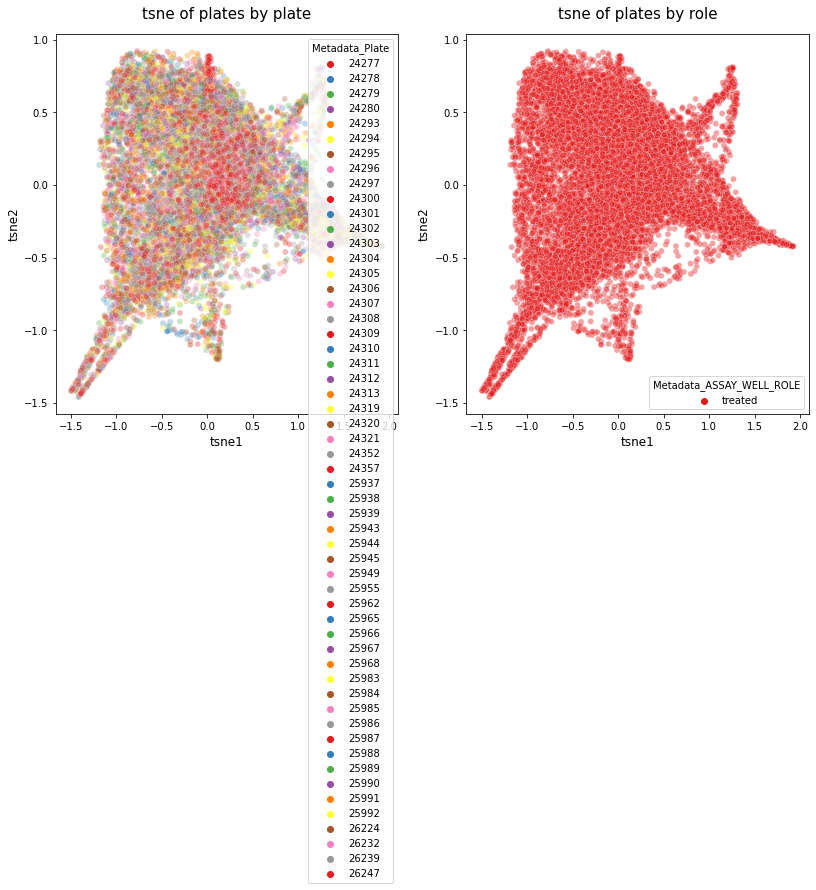

In [23]:
import matplotlib.pyplot as plt 
import seaborn as sns 

# lim =0.5
method = 'tsne'
for m in pcas.keys():
    # if model!='pure':
        a = methods[m]['zscores'][methods[m]['features']].copy()
        b = pd.DataFrame(tsnes[m],columns=[f'{method}1',f'{method}2']).copy()
        b[b>lim]=lim
        b[b<-lim]=-lim
        c = pd.concat([a.reset_index(),b],axis=1)
        # c[c['PCA1']>50]
        print(f'{m} with {c.shape}')
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.5, 7))
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_Plate',alpha=0.3, palette='Set1', ax=ax[0])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1],legend=False)
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.2, palette='Set2', ax=ax[2], legend=False)
        
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1])
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.4, palette='Set1', ax=ax[1])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_broad_sample',alpha=0.2, palette='Set1', ax=ax[3],legend=False)

        ax[0].set_title(f'{method} of plates by plate', fontsize=15, pad=15)
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        ax[1].set_title(f'{method} of plates by role', fontsize=15, pad=15)
        # ax[2].set_title("PCA of plates by sample", fontsize=15, pad=15)
        # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

        ax[0].set_xlabel(f'{method}1', fontsize=12)
        ax[0].set_ylabel(f'{method}2', fontsize=12)

        ax[1].set_xlabel(f'{method}1', fontsize=12)
        ax[1].set_ylabel(f'{method}2', fontsize=12)

        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()

DNN with (17594, 581)


/tmp/ipykernel_46427/2430220155.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


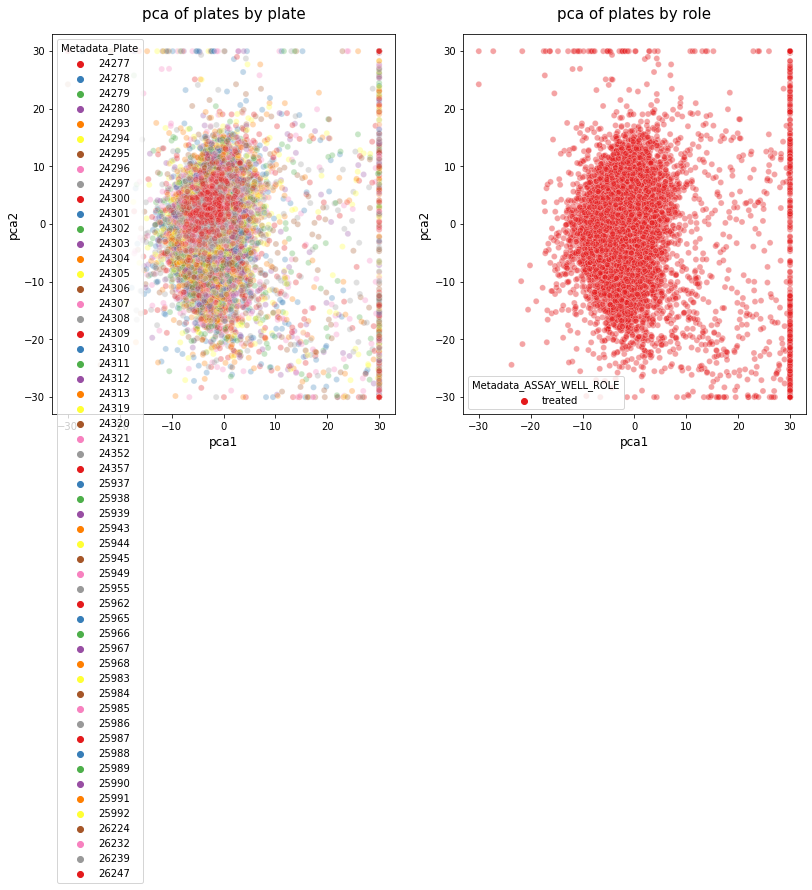

DNN with (17594, 609)


/tmp/ipykernel_46427/2430220155.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


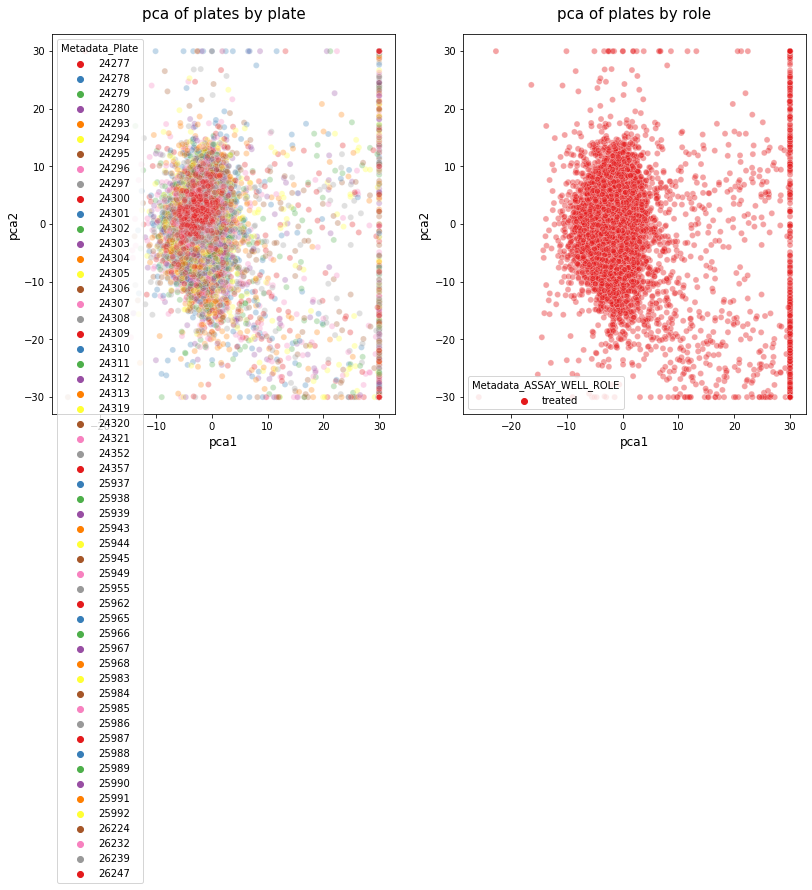

In [24]:
lim =30
method = 'pca'
for m in pcas.keys():
    # if model!='pure':
        a = methods[m]['zscores'][methods[m]['features']].copy()
        b = pd.DataFrame(pcas[m],columns=[f'{method}1',f'{method}2']).copy()
        b[b>lim]=lim
        b[b<-lim]=-lim
        c = pd.concat([a.reset_index(),b],axis=1)
        # c[c['PCA1']>50]
        print(f'{m} with {c.shape}')
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.5, 7))
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_Plate',alpha=0.3, palette='Set1', ax=ax[0])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1],legend=False)
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.2, palette='Set2', ax=ax[2], legend=False)
        
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1])
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.4, palette='Set1', ax=ax[1])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_broad_sample',alpha=0.2, palette='Set1', ax=ax[3],legend=False)

        ax[0].set_title(f'{method} of plates by plate', fontsize=15, pad=15)
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        ax[1].set_title(f'{method} of plates by role', fontsize=15, pad=15)
        # ax[2].set_title("PCA of plates by sample", fontsize=15, pad=15)
        # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

        ax[0].set_xlabel(f'{method}1', fontsize=12)
        ax[0].set_ylabel(f'{method}2', fontsize=12)

        ax[1].set_xlabel(f'{method}1', fontsize=12)
        ax[1].set_ylabel(f'{method}2', fontsize=12)

        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()

dict_keys(['anomaly', 'raw'])
anomaly with (17594, 581)


/tmp/ipykernel_46427/2999049186.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


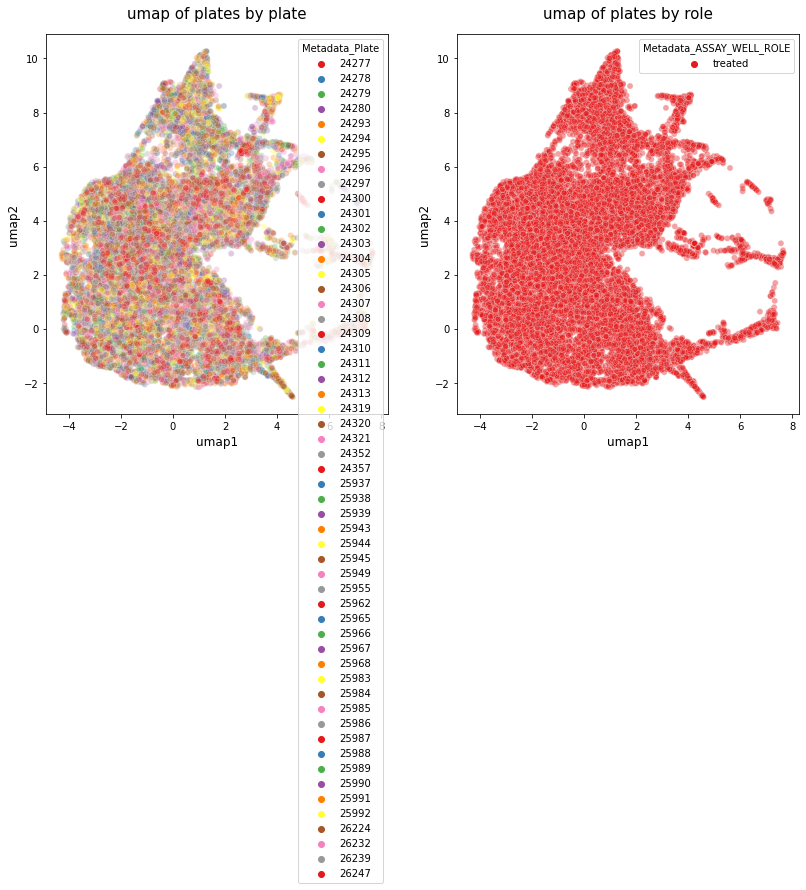

raw with (17594, 609)


/tmp/ipykernel_46427/2999049186.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


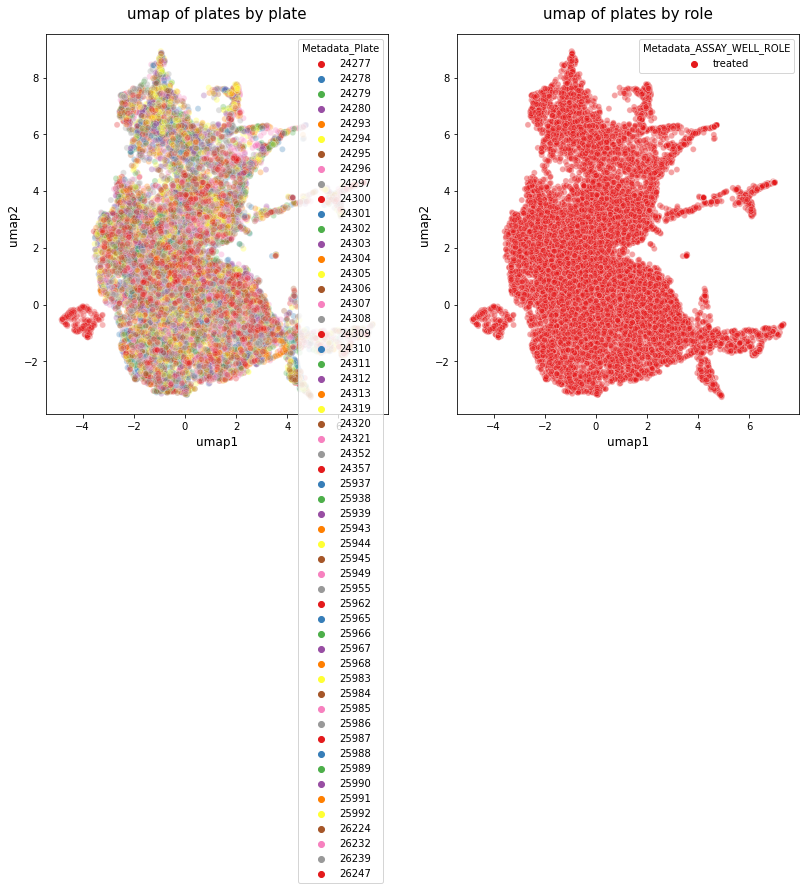

In [26]:
print(pcas.keys())
# lim =30
method = 'umap'
for m in pcas.keys():
    # if model!='pure':
        a = methods[m]['zscores'][methods[m]['features']].copy()
        b = pd.DataFrame(umaps[m],columns=[f'{method}1',f'{method}2']).copy()
        b[b>lim]=lim
        b[b<-lim]=-lim
        c = pd.concat([a.reset_index(),b],axis=1)
        # c[c['PCA1']>50]
        print(f'{m} with {c.shape}')
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.5, 7))
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_Plate',alpha=0.3, palette='Set1', ax=ax[0])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1],legend=False)
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.2, palette='Set2', ax=ax[2], legend=False)
        
        # sns.scatterplot(data =c, x='PCA1',y='PCA2', hue='Image_Metadata_Well',alpha=0.2, palette='Set2', ax=ax[1])
        sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_ASSAY_WELL_ROLE',alpha=0.4, palette='Set1', ax=ax[1])
        # sns.scatterplot(data =c, x=f'{method}1',y=f'{method}2', hue='Metadata_broad_sample',alpha=0.2, palette='Set1', ax=ax[3],legend=False)

        ax[0].set_title(f'{method} of plates by plate', fontsize=15, pad=15)
        # ax[1].set_title("PCA of plates by well", fontsize=15, pad=15)
        ax[1].set_title(f'{method} of plates by role', fontsize=15, pad=15)
        # ax[2].set_title("PCA of plates by sample", fontsize=15, pad=15)
        # ax[1].set_title("PCA of IRIS dataset", fontsize=15, pad=15)

        ax[0].set_xlabel(f'{method}1', fontsize=12)
        ax[0].set_ylabel(f'{method}2', fontsize=12)

        ax[1].set_xlabel(f'{method}1', fontsize=12)
        ax[1].set_ylabel(f'{method}2', fontsize=12)

        # plt.savefig(os.path.join(args.exp_dir,'PCA of '+ exp_name + '.png'), dpi=80)
        plt.tight_layout()
        plt.show()

In [ ]:
ncoleach = 2
ncol = ncoleach*1
nrow = 3

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*5,nrow*5), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle(f'Comapring Z-score - raw features vs. mappings by cell/well', fontsize = 24)


cols = CHANNELS+["ALL"]


symbols = ax[0,0].plot(err_cell, err_well, f'.')
ax[0,0].set_xlabel('err_cell')
ax[0,0].set_ylabel('err_well')
ax[0,1].plot(raw_cell, raw_well, f'.')
ax[0,1].set_xlabel('raw_cell')
ax[0,1].set_ylabel('raw_well')

xlab = ['raw_cell', 'raw_well']
ylab = ['err_cell', 'err_well']
i = 2

for raw, xlab in zip([raw_cell, raw_well], ['raw_cell', 'raw_well']):
    for err, ylab in zip([err_cell, err_well], ['err_cell', 'err_well']):
        ax[i//ncoleach,i%ncoleach].plot(raw, err, f'.')
        ax[i//ncoleach,i%ncoleach].set_xlabel(xlab)
        ax[i//ncoleach,i%ncoleach].set_ylabel(ylab)
        i += 1
        
for i in range(ncol*nrow):
    ax[i//ncol,i%ncol].set_yscale('symlog', base=10)
    ax[i//ncol,i%ncol].set_xscale('symlog', base=10)
    ax[i//ncol,i%ncol].set(xlim=(0, 70), ylim=(0, 70))
    ax[i//ncol,i%ncol].plot(range(-1, 100), range(-1, 100), 'b:')
    ax[i//ncol,i%ncol].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=False, left=True, right=False)
    ax[i//ncol,i%ncol].yaxis.label.set_size(12)
    ax[i//ncol,i%ncol].xaxis.label.set_size(12)
    ax[i//ncol,i%ncol].title.set_size(14)
    

fig.legend(symbols, cols, markerscale=1.6, fontsize='x-large', bbox_to_anchor=(1.06, 0.57))

plt.show()

In [ ]:
ncoleach = 2
ncol = ncoleach*6
nrow = 3

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*5,nrow*5), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle(f'Comapring Z-score - raw features vs. mappings by cell/well', fontsize = 24)

markers = ['d', '^', 'H', 'P', 'X','p']
colors = ['r', 'g', 'b', 'c', 'y', 'm']
cols = CHANNELS+["ALL"]

for arr in [cols, colors, markers]:
    arr.reverse()


symbols = cols.copy()
for j, col in enumerate(cols):
    adj_col = ncoleach*j
    symbols[j] = ax[0,0+adj_col].plot(err_cell[col], err_well[col], f'{colors[j]}{markers[j]}', markeredgecolor=(0, 0, 0, 0.2))[0]
    ax[0,0+adj_col].set_xlabel('err_cell')
    ax[0,0+adj_col].set_ylabel('err_well')
    ax[0,1+adj_col].plot(raw_cell[col], raw_well[col], f'{colors[j]}{markers[j]}', markeredgecolor=(0, 0, 0, 0.2))
    ax[0,1+adj_col].set_xlabel('raw_cell')
    ax[0,1+adj_col].set_ylabel('raw_well')

    xlab = ['raw_cell', 'raw_well']
    ylab = ['err_cell', 'err_well']
    i = 2
    for raw, xlab in zip([raw_cell[col], raw_well[col]], ['raw_cell', 'raw_well']):
        for err, ylab in zip([err_cell[col], err_well[col]], ['err_cell', 'err_well']):
            ax[i//ncoleach,i%ncoleach+adj_col].plot(raw, err, f'{colors[j]}{markers[j]}', markeredgecolor=(0, 0, 0, 0.2))
            ax[i//ncoleach,i%ncoleach+adj_col].set_xlabel(xlab)
            ax[i//ncoleach,i%ncoleach+adj_col].set_ylabel(ylab)
            i += 1

limit = max([df.max().max() for df in [raw_cell, raw_well, err_cell, err_well]])//10 *10
for i in range(ncol*nrow):
    ax[i//ncol,i%ncol].set_yscale('symlog', base=10)
    ax[i//ncol,i%ncol].set_xscale('symlog', base=10)
    ax[i//ncol,i%ncol].set(xlim=(0, limit), ylim=(0, limit))
    ax[i//ncol,i%ncol].plot(range(-1, 100), range(-1, 100), 'b:')
    ax[i//ncol,i%ncol].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=False, left=True, right=False)
    ax[i//ncol,i%ncol].yaxis.label.set_size(12)
    ax[i//ncol,i%ncol].xaxis.label.set_size(12)
    ax[i//ncol,i%ncol].title.set_size(14)
    

fig.legend(symbols, cols, loc='right', markerscale=1.6, fontsize='x-large', bbox_to_anchor=(0.3, 1))

plt.show()

In [ ]:
def get_scaler(df, by_well):
    _, _, channels = list_columns(df)
    channels_cols = [col for ch_cols in channels.values() for col in ch_cols]
    df = df[channels_cols]

    if by_well:
        df = df.groupby(by=['Plate', LABEL_FIELD, 'Metadata_broad_sample', 'Image_Metadata_Well']).apply(lambda g: g.mean())

    df_mock = df[df.index.isin(['mock'], 1)]

    scaler = StandardScaler()
    scaler.fit(df_mock)
    del df_mock
    
    return scaler

plate_num = 25708
df = load_plate_csv(f'{err_fld}/{plate_num}.csv')
scaler_err_cell = get_scaler(df, False)
scaler_err_well = get_scaler(df, True)
df = load_plate_csv(f'{raw_fld}/{plate_num}.csv')
scaler_raw_cell = get_scaler(df, False)
scaler_raw_well = get_scaler(df, True)


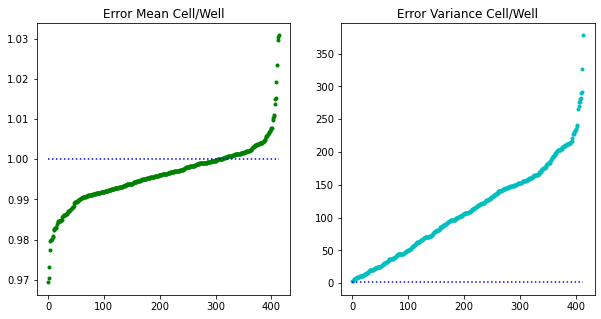

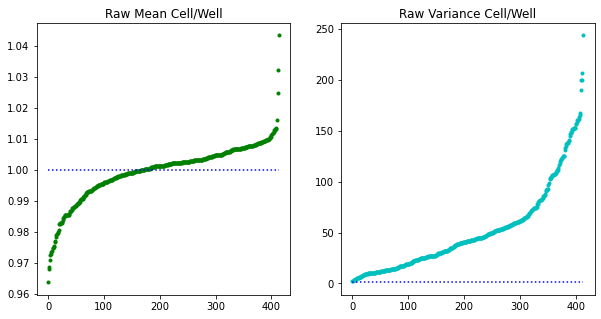

In [13]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(2*5,1*5))

ratio_err_mean = scaler_err_cell.mean_/scaler_err_well.mean_
ratio_err_mean.sort()
ax1[0].plot(range(414), ratio_err_mean, 'g.')
ax1[0].set_title('Error Mean Cell/Well')

ratio_err_var = scaler_err_cell.var_/scaler_err_well.var_
ratio_err_var.sort()
ax1[1].plot(range(414), ratio_err_var, 'c.')
ax1[1].set_title('Error Variance Cell/Well')


fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(2*5,1*5))

ratio_raw_mean = scaler_raw_cell.mean_/scaler_raw_well.mean_
ratio_raw_mean.sort()
ax2[0].plot(range(414), ratio_raw_mean, 'g.')
ax2[0].set_title('Raw Mean Cell/Well')

ratio_raw_var = scaler_raw_cell.var_/scaler_raw_well.var_
ratio_raw_var.sort()
ax2[1].plot(range(414), ratio_raw_var, 'c.')
ax2[1].set_title('Raw Variance Cell/Well')


for ax in [ax1, ax2]:
    for sub_ax in ax:
#         sub_ax.set_yscale('symlog', base=10)
#         sub_ax.set_xscale('symlog', base=10)
        sub_ax.plot(range(414), [1]*414, 'b:')